In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

# Initialise random number generators.
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

###### Importing MNIST database

In [2]:
from keras.datasets import mnist

# Define the dimensions (in pixels) of the input images.
# Each pixel will correspond to a value of a matrix.
img_width = 28
img_height = 28

# Define the form of the output.
# The machine will try to classify the input in one of ten digits.
n_classes = 10

# Download the database
(in_training, out_training), (in_validation, out_validation) = mnist.load_data()

# Reshape the input data.
# x.shape[0] is the number of samples.
if keras.backend.image_data_format() == "channels_first":
    in_training = in_training.reshape(in_training.shape[0], 1, img_width, img_height)
    in_validation = in_validation.reshape(in_validation.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    in_training = in_training.reshape(in_training.shape[0], img_width, img_height, 1)
    in_validation = in_validation.reshape(in_validation.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

# MNIST gives data as integers from 0 to 255 (= grayscale level of the pixel).
# I need it to be a value between 0 and 1, so I will rescale it.
in_training = in_training.astype("float32")
in_validation = in_validation.astype("float32")
in_training /= 255
in_validation /= 255

# The output will be a 10-entries vector, each value representing the probability
# that the corresponding digit is the correct one.
# The output data needs to be "converted" in this format.
out_training = keras.utils.to_categorical(out_training, n_classes)
out_validation = keras.utils.to_categorical(out_validation, n_classes)

Using TensorFlow backend.


###### Definition of the neural network

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()

# Add input convolutional layer.
model.add(Conv2D(
    10, # dimension of the output space
    kernel_size = (5, 5), # height and width of the convolution window
    padding = "same",
    activation = "relu",
    input_shape = input_shape
))

model.add(Dropout(0.2))

# Add a middle pooling layer, and then some.
model.add(MaxPooling2D(
    pool_size = (2, 2),
    strides = 2,
    padding = "same"
    # "same" padding adds zeros beyond the limits of the pooled array
    # so that every value is included in the calculations.
    # "valid" padding stops when it reaches the end of the array,
    # dropping the values at the borders if thery cannot be included
    # in the pool.
))

# Add a Flatten model to transition from a convolution layer to a
# linear layer.
model.add(Flatten())

# The finaly layer is necessarily a ten-neurons linear layer,
# since it must classify the data in ten classes.
model.add(Dense(
    n_classes,
    activation = "softmax"
))

I tried adding another convolution+pooling couple of layers, but the results got way worse: during the first epoch of training the accuracy never reached 0.3 and then kept on decreasing.
Maybe the parameters I chose were not quite right, but anyway using the configuration above gives pretty good results.

###### Network training
I use the *adadelta* optimizer since it was the one that performed best in the previous exercise.

In [4]:
from keras.optimizers import SGD

batch_size = 32
n_epochs = 6

model.compile(
   loss = keras.losses.categorical_crossentropy,
   optimizer = "adadelta",
   metrics = ["accuracy"]
)

# As the training advances, save the progress of the validation
# in the "history" object.
history = model.fit(
    in_training,
    out_training,
    batch_size = batch_size,
    epochs = n_epochs,
    verbose = 1,
    validation_data = (in_validation, out_validation)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 27s 454us/step - loss: 0.2194 - acc: 0.9352 - val_loss: 0.1118 - val_acc: 0.9709
Epoch 2/6
60000/60000 [==============================] - 25s 415us/step - loss: 0.0988 - acc: 0.9711 - val_loss: 0.0769 - val_acc: 0.9781
Epoch 3/6
60000/60000 [==============================] - 29s 484us/step - loss: 0.0785 - acc: 0.9769 - val_loss: 0.0669 - val_acc: 0.9797
Epoch 4/6
60000/60000 [==============================] - 26s 428us/step - loss: 0.0694 - acc: 0.9795 - val_loss: 0.0554 - val_acc: 0.9821
Epoch 5/6
60000/60000 [==============================] - 28s 460us/step - loss: 0.0627 - acc: 0.9816 - val_loss: 0.0548 - val_acc: 0.9823
Epoch 6/6
60000/60000 [==============================] - 28s 466us/step - loss: 0.0594 - acc: 0.9820 - val_loss: 0.0514 - val_acc: 0.9833


###### Evaluation results

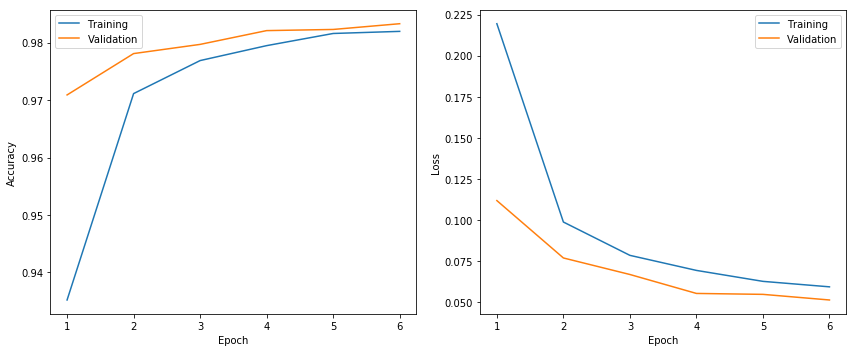

In [5]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()
epochs = range(1, 7)

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].plot(epochs, history.history["acc"])
axes[0].plot(epochs, history.history["val_acc"])
axes[0].legend(["Training", "Validation"])

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].plot(epochs, history.history["loss"])
axes[1].plot(epochs, history.history["val_loss"])
axes[1].legend(["Training", "Validation"])

fig.tight_layout()
plt.show()

After having run some simulations, it seemed to me that the validation accuracy peaked after six or seven epochs, same for the loss. Therefore, I set the network to train for six epochs only, to avoid overfitting issues.

###### Predictions
Now that the network is trained, it can be used to guess some digits.

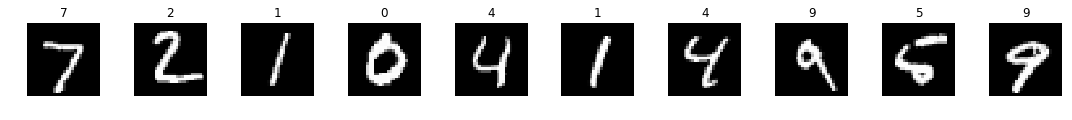

In [6]:
test = in_validation.reshape(in_validation.shape[0], img_width, img_height, 1) #?

fig, axes = plt.subplots(nrows = 1, ncols = 10, figsize = (15, 15))
axes = axes.flatten()

prediction = model.predict(in_validation)
for i in range(10):
    axes[i].imshow(test[i, :, :, 0], cmap = "gray")
    axes[i].set_title(np.argmax(prediction[i]))
    axes[i].axis("off")

fig.tight_layout()
plt.show()

Comparing it with the linear network that used the *adadelta* optimizer in the previous exercise, this convolutional neural network scores a higher accuracy and a lower loss. 

In [7]:
# Save the model to reuse it in the following exercise.
save_model_path = "digit_recognition_network"
model.save(filepath = save_model_path, include_optimizer = True)